# Summarization query oriented

__TO DO__ :
- DocEmbedding with shifted LSTM
- How to select partial summary during training ? Only part from the beginning or randomly chosen sentences ?
- Generator of triplets 
- Metric for monitoring the test (See pyrouge) on a val set

 <hr style="border-color:#1d539d"> 

## Initialization

In [1]:
import bisect
import collections
import copy
import gensim
import json
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import random
import time

Using Theano backend.


In [2]:
# paths to folders

data_json = "/home/ubuntu/summarization_query_oriented/data/json/patch_0/"
data_txt = "/home/ubuntu/summarization_query_oriented/data/txt/"
model_folder = "/home/ubuntu/summarization_query_oriented/models/"
nn_models_folder = "/home/ubuntu/summarization_query_oriented/nn_models/"

## Doc2vec

In [3]:
# parameters of doc2vec
dm = 0
min_count = 5
window = 10
size = 400
sample = 1e-4
negative = 5
workers = 4
epoch = 20

# Initialize the model ( IMPORTANT )
d2v_model = gensim.models.doc2vec.Doc2Vec(dm=dm,min_count=min_count, window=window, size=size, sample=sample, negative=negative, workers=workers,iter = epoch)

# load model
model_name ="dm_"+str(dm)+"_mc_"+str(min_count)+"_w_"+str(window)+"_size_"+str(size)+"_neg_"+str(negative)+"_ep_"+str(epoch)
d2v_model = d2v_model.load(model_folder+model_name+".d2v")
print("model loaded")

model loaded


## Models 

### Model 1 : fully connected model


* __Architecture__ : Fully connected model


* __Input__ : a vector that is the concatenation of [ query , partial summary, candidate ]
    * *query* : here the subtitle of a wikipedia page
    * *partial summary* : here a part (eventually void) of the summary attached to this subtitle
    * *candidate* : a random sentence


* __Output__ : a score describing how much the candidate sentence is completing the partial summary w.r.t the query 


* __Training mode__ : we sample triplet from wikipedia data to build the training set, we label 1 if the candidate sentence is a sentence of the correct subsection that is not in the partial summary (by building), we label 0 otherwise


* __Testing mode__ : Given a document and a query. The partial summary is initialized as the query, then we choose the sentence of the document that is not in the partial summary with the highest score and delete it from the document. We repeat it until we reach the length limit

#### Data Processing 

Here we build functions to perform end—to-end data preparation

In [11]:
# functions

non_selected_keys = ["title", "external links","further reading","references","see also"]

def has_at_least_one_relevant_key(file_as_dict):
    
    for key in file_as_dict.keys():
        b = True
        for unwanted_key in non_selected_keys:
            if unwanted_key in key.lower() :
                b = False    
        if b :
            return True
    return False
        
def has_irrelevant_content(file_as_dict):
    # remove articles with mathematics of chemics
    for key in file_as_dict.keys():
        if "{\\" in file_as_dict[key]:
            return True        

    # check that there is at least one interesting key
    if not has_at_least_one_relevant_key(file_as_dict):
        return True

    return False


def relevant_articles(article_folder_path, min_size = 10000) : 
    """
    inputs :
        - absolute path of the folder containing all the json articles
        - min_size : retaining only file with at least size = min_size*10^-4 ko
    output : 
        - article_names: nd array of the names of the relevant articles (absolute paths)
        - article_weights : nd array normalized of the weights of each files
    """
    all_names =  [f for f in listdir(article_folder_path)]
    article_names = []
    article_weights = []
    for name in all_names:
        article_weight = os.path.getsize(article_folder_path+name)
        if article_weight > min_size:
            # the size of the article meets the requirement
            
            with open(article_folder_path+name) as f :
                file_as_dict = json.load(f) # get article as dict
            
            if not has_irrelevant_content(file_as_dict):
                article_names.append(article_folder_path+name)
                article_weights.append(article_weight)
    
    article_names = np.asarray(article_names)
    article_weights = (np.asarray(article_weights) + 0.0) / np.sum(article_weights)
        
    return article_names, article_weights
            
def select_key(file_as_dict):
    assert has_at_least_one_relevant_key(file_as_dict), "the file has no relevant key"

    keys = file_as_dict.keys()
    rand_idx = np.random.randint(0,len(keys))
    selected_key = keys[rand_idx]
    
    if len(file_as_dict[selected_key].split("."))<=2:
        return select_key(file_as_dict)
    
    for unwanted_key in non_selected_keys :
        if unwanted_key in selected_key.lower() :
            return select_key(file_as_dict)
        
    return selected_key

def create_triplets(d2v_model, article_names, article_weights, nb_triplets=20, triplets_per_file=5, neg_ratio=0.5, str_mode = False) :
    """
    inputs :    
        - d2v_model : paragraph vector model 
        - article_names : ndarray containing the names of the json files (absolute path !)
        - article_weights: ndarray normalized of the weight of each files 
        - nb_triplets : nb of triplets to generate
        - triplets_per_file : number of triplet built for each selected file
        - neg_ratio : ratio of positives / negative examples. Negative examples are taken inside the article !
        
    output : 
        - triplets : nd_array of triplets of shape (nb_triplets+ , embed_dim)
        - labels : nd_array of labels of shape (nb_triplets+ ,)

    """
    triplets = []
    labels = []
    
    assert nb_triplets>=triplets_per_file, "you should have nb_triplets > triplets_per_file"
    
    # nb of pos / neg triplets per file
    neg_per_file = np.floor(triplets_per_file*neg_ratio) #number of negative triplets to generate given(query + partial summary)
    assert neg_per_file >= 1, "you have to increase your neg_ratio"
    
    nb_files = nb_triplets / triplets_per_file
    selected_files_array = np.random.choice(article_names, size=nb_files, p=article_weights, replace = False)
    
    for full_name in selected_files_array :
        with open(full_name) as f :
            file_as_dict = json.load(f)
        
        counter = 0
        while counter < triplets_per_file :
            
            # select a key for positive examples
            key_pos = select_key(file_as_dict)
            
            triplet = build_triplet(d2v_model, file_as_dict, key_pos, positive = True, str_mode = str_mode)
            label = 1
            
            triplets.append(triplet)
            labels.append(label)
            counter += 1 
            
            if neg_ratio < 1 : 
                
                if np.random.rand() < neg_ratio :
                    
                    triplet = build_triplet(d2v_model, file_as_dict, key_pos, positive = False, str_mode = str_mode)
                    label = 0
                    
                    triplets.append(triplet)
                    labels.append(label)
                    counter += 1 

            else :
                
                for n in range(int(np.floor(neg_ratio))):
                    
                    triplet = build_triplet(d2v_model, file_as_dict, key_pos, positive = False, str_mode = str_mode)
                    label = 0
                    
                    triplets.append(triplet)
                    labels.append(label)
                    counter += 1 

            
    triplets = np.asarray(triplets)[:nb_triplets]
    labels = np.asarray(labels)[:nb_triplets]
    
    return triplets, labels

def build_triplet(d2v_model, file_as_dict, key_pos, positive = True, str_mode = False):

    query_str = key_pos
    query_prep = gensim.utils.simple_preprocess(query_str, deacc=True)
    query_vector = d2v_model.infer_vector(query_prep)
    
    summary_str = file_as_dict[key_pos]
    sentences = summary_str.split(".")
    
    partial_summary = []
    candidates = []
    
    size_partial_summary = np.random.rand()
    
    for sentence in sentences: 
        if np.random.rand() < size_partial_summary :
            partial_summary.append(sentence)
        else :
            candidates.append(sentence)
    
    candidate = ""
    counter_candidate = 0
    while (candidate == "" or partial_summary == "") and counter_candidate < 10:
        counter_candidate += 1
        
        if positive : 
            if len(candidates) > 0:
                random_candidate_index = np.random.randint(0,len(candidates))
                candidate = candidates[random_candidate_index]
            else :
                random_candidate_index = np.random.randint(0,len(partial_summary))
                candidate = partial_summary[random_candidate_index]
                partial_summary[random_candidate_index] = ""


            candidate_prep = gensim.utils.simple_preprocess(candidate, deacc=True)
            candidate_vector = d2v_model.infer_vector(candidate_prep)

        else :

            key_neg = select_key(file_as_dict)
            counter = 0

            while key_neg == key_pos and counter<10 : # the counter is for the preproduction code 
                counter += 1
                key_neg = select_key(file_as_dict)

            summary_str = file_as_dict[key_neg]

            sentences = summary_str.split('.')
            random_candidate_index = np.random.randint(0,len(sentences))
            candidate = sentences[random_candidate_index]
            candidate_prep = gensim.utils.simple_preprocess(candidate, deacc=True)
            candidate_vector = d2v_model.infer_vector(candidate_prep)
        
        partial_summary_str = "".join(partial_summary)
        partial_summary_prep = gensim.utils.simple_preprocess(partial_summary_str, deacc=True)
        partial_summary_vector = d2v_model.infer_vector(partial_summary_prep)
    
    if str_mode :
        return query_str, partial_summary_str, candidate
    else :
        return np.hstack( [query_vector, partial_summary_vector, candidate_vector] )



In [12]:
# data processing
article_names, article_weights = relevant_articles(data_json)

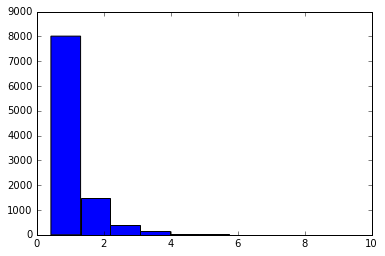

In [16]:
plt.figure()
plt.hist(article_weights*10000)
plt.show()

#### ILLUSTRATION BLOCK : Here you can play with the triplet maker and see what gives triplet labelisation 

In [19]:
triplets, labels = create_triplets(d2v_model, article_names, article_weights, nb_triplets=25, triplets_per_file=8, neg_ratio=1, str_mode = True)

for i in range(len(labels)):
    print 50*'-'
    print "label = ", labels[i]
    print "\nquery :", triplets[i][0]
    print "\npartial summary :", triplets[i][1]
    print "\ncandidate :", triplets[i][2]

--------------------------------------------------
label =  1

query : Internet Relay Chat History EFnet

partial summary : In August 1990 the first major disagreement took place in the IRC world The "A-net" (Anarchy net) included a server named erisberkeley In wumpus' words again: "Eris refused to remove that line, so I formed EFnet It wasn't much of a fight; I got all the hubs to join, and almost everyone else got carried along" A-net was formed with the eris servers, EFnet was formed with the non-eris servers History showed most servers and users went with EFnet Once ANet disbanded, the name EFnet became meaningless, and once again it was the one and only IRC network
It is around that time that IRC was used to report on the 1991 Soviet coup d'état attempt throughout a media blackout It was previously used in a similar fashion during the Gulf War Chat logs of these and other events are kept in the ibiblio archive

candidate : edu
--------------------------------------------------
lab

#### Define model

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam


fc_model_name = nn_models_folder + time.strftime("%Y_%m_%d_") +'_fc_model.h5' # replace it with hour of training

fc_model = Sequential()

fc_model.add(Dense(120, input_dim=1200))
fc_model.add(Activation('sigmoid'))
fc_model.add(Dropout(0.5))

fc_model.add(Dense(12))
fc_model.add(Activation('sigmoid'))
fc_model.add(Dropout(0.5))

fc_model.add(Dense(1))
fc_model.add(Activation('sigmoid'))

In [34]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
fc_model.compile(loss="binary_crossentropy", optimizer=adam)

#### Training (we use training per batch)

In [86]:
batch_size = 128
for i in range(200):
    if i%10 == 0 : 
        print(i)
    triplets, labels = create_triplets(d2v_model, article_names, article_weights, nb_triplets=batch_size, triplets_per_file=16, neg_ratio=1, str_mode = False)
    fc_model.train_on_batch(triplets, labels)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [117]:
triplets_tests , labels_tests = create_triplets(d2v_model, article_names, article_weights, nb_triplets=128, triplets_per_file=16, neg_ratio=1, str_mode = False)
labels_predicted = fc_model.predict(triplets_tests , batch_size=batch_size, verbose=1)

128/128 [==============================] - 0s


In [47]:
loss_and_metrics = fc_model.evaluate(triplets_tests, labels_tests, batch_size=batch_size)
print(loss_and_metrics)

128/128 [==============================] - 0s
0.693373680115


In [49]:
labels_tests

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

#### Saving

In [24]:
from keras.models import load_model

fc_model.save(fc_model_name)  # creates a HDF5 file 'my_model.h5'

del fc_model  # deletes the existing model
# returns a compiled model
# identical to the previous one
fc_model = load_model(fc_model_name)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/models.py:136: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
fc_model = load_model(fc_model_name)

#### General info on the model

In [26]:
print(fc_model.summary())
print(fc_model.get_config())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 120)           144120      dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 120)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 120)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 12)            1452        dropout_1[0][0]                  
___________________________________________________________________________________________

#### Testing the model

In [27]:
def summarize(text, query, d2v_model, nn_model, limit = 2000):

    query_prep = gensim.utils.simple_preprocess(query, deacc=True)
    query_vector = d2v_model.infer_vector(query_prep)
    
    summary  = ""
    summary_vector = d2v_model.infer_vector([""])
    summary_idx = []
    
    sentences = text.split('.')
    sentences = np.asarray(sentences)
    
    remaining_sentences = copy.copy(sentences)
    
    size = 0
    counter = 0
    while size < limit and len(remaining_sentences)>0 :
        counter = counter+1

        for sentence in remaining_sentences :
            
            scores = []
            sentence_prep = gensim.utils.simple_preprocess(sentence, deacc=True)
            sentence_vector = d2v_model.infer_vector(sentence_prep)

            nn_input = np.hstack([query_vector, summary_vector, sentence_vector])
            nn_input = np.asarray([nn_input]) # weird but it is important to do it
            score = nn_model.predict(nn_input) 
            scores.append(score)
            
        max_idx_rem = int(np.argmax(scores))
        idx_selected_sentence = np.arange(len(sentences))[sentences == remaining_sentences[max_idx_rem]]
        idx_selected_sentence = int(idx_selected_sentence[0])
        size += len(remaining_sentences[max_idx_rem])
        remaining_sentences = list(remaining_sentences)
        del remaining_sentences[max_idx_rem]
        bisect.insort_left(summary_idx,idx_selected_sentence)

        summary  = ""

        for idx in summary_idx:
            summary = summary + " " + sentences[idx]

        summary_prep = gensim.utils.simple_preprocess(summary, deacc=True)
        summary_vector = d2v_model.infer_vector(summary_prep)

    return summary

In [28]:
wikipedia_title = "History of Israel"
with open(data_json+wikipedia_title+".json", 'r') as f:
    wiki_as_json = json.load(f)

text = ""
for key in wiki_as_json.keys():
    if key not in non_selected_keys:
        text += " " + wiki_as_json[key]
        
random_idx = np.random.randint(0,len(wiki_as_json.keys()))
query = wiki_as_json.keys()[random_idx]
summary_true = wiki_as_json[query]
limit_size = len(wiki_as_json[query])

print 50*"*"
print 'query', query
print 50*"*"
print "real summary\n\n", summary_true
print 50*"*"
print "nn summary\n\n", summarize(text,query,d2v_model, fc_model, limit = limit_size)

**************************************************
query History of Israel Babylonian rule (586–538 BCE)
**************************************************
real summary

In 586 BCE King Nebuchadnezzar II of Babylon conquered Judah. According to the Hebrew Bible, he destroyed Solomon's Temple and exiled the Jews to Babylon. The defeat was also recorded by the Babylonians (see the Babylonian Chronicles). Babylonian and Biblical sources suggest that the Judean king, Jehoiachin, switched allegiances between the Egyptians and the Babylonians and that invasion was a punishment for allying with Babylon's principal rival, Egypt. The exiled Jews may have been restricted to the elite.
Jehoiachin was eventually released by the Babylonians (see Jehoiachin's Rations Tablets) and according to both the Bible and the Talmud, the Judean royal family (the Davidic line) continued as head of the exile in Babylon (the Exilarch).
**************************************************
nn summary

  The British E

### Model 2 : LSTM

#### data processing 

#### define model

#### training

#### testing

#### saving

In [68]:
import copy
list1 = [1,2,3,4]
list2 = copy.copy(list1)
del list1[0]
print (list1)
print (list2)

[2, 3, 4]
[1, 2, 3, 4]


In [192]:
a = [0]
a.sort()
a


[0]